#  基于 Attention 机制的 Seq2seq 模型

TensorFlow 2.X，基于 Attention 机制的 Seq2seq 模型。

来源：[https://www.tensorflow.org/tutorials/text/nmt_with_attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention)

训练一个将西班牙语翻译为英语的神经机器翻译（NMT） Seq2seq 模型。Seq2seq 模型由 Encoder RNN 和 Decoder RNN 构。

输入一个西班牙语句子，例如 "¿todavia estan en casa?"，并返回其英语翻译 "are you still at home?"

In [2]:
import re
import os
import io
import time
import unicodedata

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import tensorflow as tf

tf.__version__

'2.2.0-rc3'

## 数据

数据来源：[Tab-delimited Bilingual Sentence Pairs](http://www.manythings.org/anki/)

我下载了西班牙语-英文的数据。

In [ ]:
# 文件路径
path_to_file = "../../dataset/spa-eng/spa.txt"

In [ ]:
def unicode_to_ascii(s):
    """
    将 unicode 文件转换为 ascii
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    """
    处理句子
    """
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

def create_dataset(path, num_examples):
    """
    创建数据集
    """
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [5]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def max_length(tensor):
    """
    找出最大长度
    """
    return max(len(t) for t in tensor)

def tokenize(lang):
    """
    分词
    """
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    """
    载入数据
    """
    # 创建清理过的输入输出对
    targ_lang, inp_lang = create_dataset(path, num_examples)
    
    # 进行分词
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# 尝试实验不同大小的数据集
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [8]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [10]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
39 ----> las
256 ----> amo
10 ----> a
39 ----> las
98 ----> dos
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
77 ----> love
6 ----> you
266 ----> both
3 ----> .
2 ----> <end>


### 创建一个 tf.data 数据集

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## Seq2seq 模型

### Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [14]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


### Attention

编码器采用 [Bahdanau 注意力](https://arxiv.org/pdf/1409.0473.pdf)。

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 隐藏层的形状 == （批大小，隐藏层大小）
        # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
        # 这样做是为了执行加法以计算分数  
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # 分数的形状 == （批大小，最大长度，1）
        # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
        # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
        attention_weights = tf.nn.softmax(score, axis=1)

        # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [16]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


### Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # 用于注意力
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
        x = self.embedding(x)

        # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 将合并后的向量传送到 GRU
        output, state = self.gru(x)

        # 输出的形状 == （批大小 * 1，隐藏层大小）
        output = tf.reshape(output, (-1, output.shape[2]))

        # 输出的形状 == （批大小，vocab）
        x = self.fc(output)

        return x, state, attention_weights

In [18]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


### 定义优化器和损失函数

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### 检查点（基于对象保存）

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 训练

训练过程为：
- 将“输入”传送至“编码器”，编码器返回“编码器输出”和“编码器隐藏层状态”。
- 将“编码器输出”、“编码器隐藏层状态”和“输入（即，开始标记）”传送至解码器。
- 解码器返回“预测”和“解码器隐藏层状态”。
- “解码器隐藏层状态”被传送回模型，预测被用于计算损失。
- 使用“教师强制 （teacher forcing）”决定解码器的下一个输入。（“教师强制”是将“目标词”作为 下一个输入 传送至解码器的技术。）
- 最后一步是计算梯度，并将其应用于优化器和反向传播。

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # 教师强制 - 将目标词作为下一个输入
        for t in range(1, targ.shape[1]):
            # 将编码器输出 （enc_output） 传送至解码器
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # 使用教师强制
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [22]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # 每 2 个周期（epoch），保存（检查点）一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6989
Epoch 1 Batch 100 Loss 2.2641
Epoch 1 Batch 200 Loss 1.8457
Epoch 1 Batch 300 Loss 1.8409
Epoch 1 Loss 2.0325
Time taken for 1 epoch 85.92029404640198 sec

Epoch 2 Batch 0 Loss 1.4817
Epoch 2 Batch 100 Loss 1.4885
Epoch 2 Batch 200 Loss 1.3261
Epoch 2 Batch 300 Loss 1.3324
Epoch 2 Loss 1.3866
Time taken for 1 epoch 69.85401916503906 sec

Epoch 3 Batch 0 Loss 1.1020
Epoch 3 Batch 100 Loss 1.0622
Epoch 3 Batch 200 Loss 1.0063
Epoch 3 Batch 300 Loss 0.9807
Epoch 4 Batch 0 Loss 0.7255
Epoch 4 Batch 100 Loss 0.7325
Epoch 4 Batch 200 Loss 0.6828
Epoch 4 Batch 300 Loss 0.6281
Epoch 4 Loss 0.6537
Time taken for 1 epoch 69.57843732833862 sec

Epoch 5 Batch 0 Loss 0.4642
Epoch 5 Batch 100 Loss 0.4631
Epoch 5 Batch 200 Loss 0.3444
Epoch 5 Batch 300 Loss 0.4061
Epoch 5 Loss 0.4418
Time taken for 1 epoch 69.07223606109619 sec

Epoch 6 Batch 0 Loss 0.3377
Epoch 6 Batch 100 Loss 0.2488
Epoch 6 Batch 200 Loss 0.3420
Epoch 6 Batch 300 Loss 0.3308
Epoch 6 Loss 0.3060
Time tak

## 评估（进行翻译）

- 评估函数类似于训练循环，不同之处在于在这里我们不使用“教师强制”。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
- 当模型预测到“结束标记”时停止预测。
- 存储“每个时间步的注意力权重”。

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### 恢复最新的检查点并验证

In [26]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


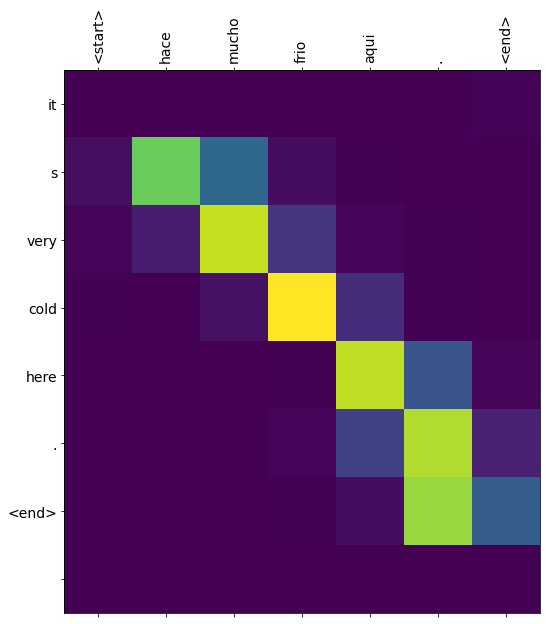

In [27]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


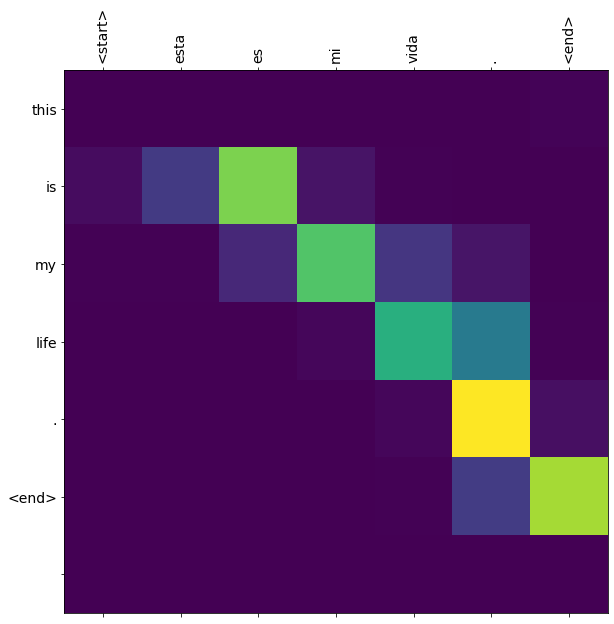

In [28]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


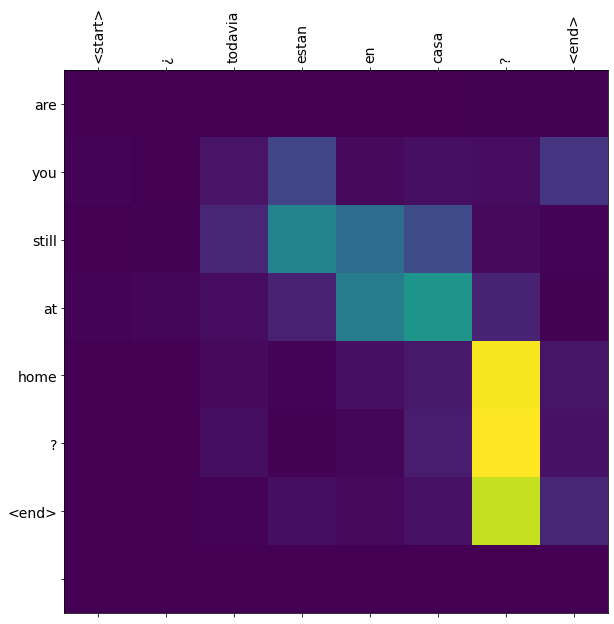

In [29]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to find out . <end> 


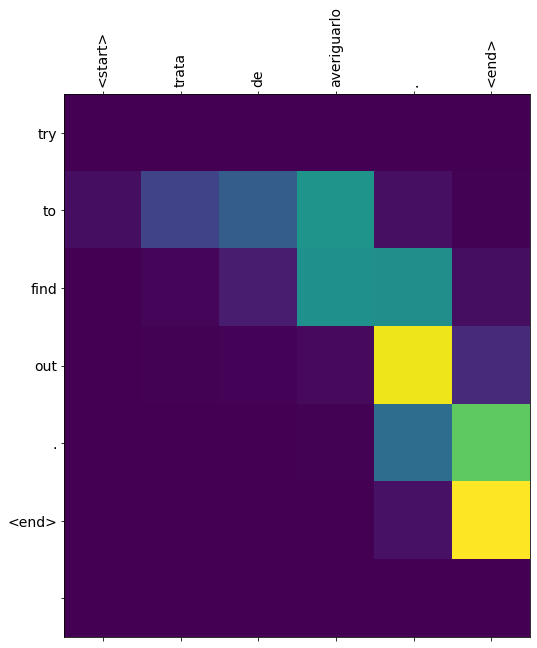

In [30]:
# 错误的翻译
translate(u'trata de averiguarlo.')